In [1]:
#General use
import numpy as np
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo

#For creating a list of .fits files to perform photometry on
import os

#For reading and creating tables
from astropy.table import Table, unique, vstack, join
import astropy.io.ascii as asc

#For performing photometry
from astropy import units as u
from photutils import aperture_photometry, SkyCircularAperture, CircularAperture
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

#For generating a plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline


/Users/Daniel/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [8]:
def Conv_error(val, err): 

    '''
    Find error in the conversion factor from kpc^2 to arcmin^2 using a black box error method.

    Args:
        val (float): A redshift value
        err (float): Error in the redshift
        
    Returns:
        error (float): Error in the conversion factor
    '''

    error = abs(.5 * (
                (cosmo.kpc_comoving_per_arcmin(val + err))**2
                 - (cosmo.kpc_comoving_per_arcmin(val - err))**2
                )).value
    
    return(error)

def lum_dist_error(val, err): 
    
    '''
    Find error in the luminosity distance using a black box error method

    Args:
        val (float): A redshift value
        err (float): Error in the redshift
        
    Returns:
        error (float): Error in the luminosity distance 
    '''

    error = abs(.5 * (cosmo.luminosity_distance(val + err).cgs
                 - cosmo.luminosity_distance(val - err).cgs)).value 
    
    return(error)

def Flux_error(pho_val, pho_err, conv_val, conv_err):

    '''
    Find error in the calculated flux due to error in the measured photon counts per second
    and flux conversion factor.
    
    Args:
        pho_val  (float): Average photon counts per second
        pho_err  (float): Error in pho_val
        conv_val (float): A conversion factor from average photon counts to flux
        conv_err (float): Error in conv_val
        
    Returns:
        error (float): Error in the associated flux value
    '''

    error = ((pho_val * conv_err)**2 + (conv_val * pho_err)**2)**(.5)
    return(error)

def Luminosity_error(flux_val, flux_err, dist_val, dist_err): 

    '''
    Find error in the calculated Luminosity due error in the flux and luminosity distance 
    
    Args:
        flux_val (float): Average photon counts per second
        flux_err (float): Error in val
        dist_val (float): Comoving distance
        dist_err (float): Error in comoving distance
        
    Returns:
        error (float): Error in the luminosity
    '''

    error = ((4 * np.pi * (dist_val**2) * flux_err)**2
             + (8 * np.pi * dist_val * flux_val * dist_err)**2)**(.5)
    
    return(error)

def Sbrightness_error(lum_val, lum_err, conv_val, conv_err):
    
    '''
    Find the error in surface brightness 
    
    Args:
        lum_val  (float): Luminosity of a supernova environment
        lum_err  (float): Error in the luminosity
        conv_val (float): Conversion factor from arcmin^2 to Kpc^2 
        conv_err (float): Error in the conversion factor
        
    Returns:
        error (float): Error in the Surface brightness
    '''
    
    error = ((conv_val * lum_err / 3600)**2
             + (lum_val * conv_err / 3600)**2)**(.5)
    
    return(error)

def zero_check(fits_file, cord, r):

    '''
    Perform photometry on a wt type .fits file and checks if there are data pixels in an 
    aperture.
    
    Args:
        fits_file (str)      : The file path of a .fits file
        cord      (SkyCoord) : The (ra, dec) of a supernova in degrees
        r         (Quantity) : The radius of a photometry aperture in arcmin.

    Returns:
        in_file         (bool): [supernova name(string), photometry value (float), exposure time (float)]
        'no check file' (str) : Returned if there is no check file
    '''

    if(os.path.isfile(fits_file.replace('d-int', 'd-wt'))):
        
        hdulist = fits.open(fits_file.replace('d-int', 'd-wt'))
        aperture = SkyCircularAperture(cord, r)
        phot_table = aperture_photometry(hdulist[0], aperture)
        in_file = phot_table[0][0]!=0
        return(in_file)
    
    else:
        return('no check file')

def photometry(fits_file, radius):
    
    '''
    Perform photometry on a .fits file. 
    
    Args:
        fits_file (str)  : The file path of a .fits file
        radius    (float): Radius of the desired aperture in kpc

    Returns:
        results               (list): [supernova name (string), photometry value (float),
                                        exposure time (float)]
                                        
        'no check file'       (str) : Returned if photometry of a supernova is zero and 
                                        there was no check file
                                        
        'failed check file'   (str) : Returned if no supernova is found in the .fits file
    '''
    
    #open the file and create an hdulist
    hdulist = fits.open(fits_file)
    sci = hdulist[0].data
    wcs = WCS(fits_file)

    for sn in cord:

        #Define the SN location in pixels
        w = wcs.all_world2pix(cord[sn].ra,cord[sn].dec, 1)
        
        #Make sure the sn is located in the image
        if 0<w[0]<3600 and 0<w[1]<3600:

            #get exposure time and create an array of the error in each pixel
            exp_time = hdulist[0].header['EXPTIME']
            error = ((hdulist[0].data*exp_time)**(.5)) / exp_time
            
            #Find arcmin of a 1kpc radius region
            r = radius * u.kpc / cosmo.kpc_comoving_per_arcmin(float(red[sn]))
            
            #Create an aperture
            aperture = SkyCircularAperture(cord[sn], r) 
            
            #Perform photometry
            phot_table = aperture_photometry(hdulist[0], aperture, error=error)
            results = [sn, phot_table, exp_time]
            
            if phot_table[0][0]!=0 or zero_check(fits_file, cord[sn], r)==True:
                return(results)
            
            elif zero_check(fits_file, cord[sn], r)=='no check file':
                return('no check file')
            
            elif zero_check(fits_file, cord[sn], r)==False:
                return('failed check file')
            
    hdulist.close()
    return(False)

def create_tables(uv_type, directory, radius):
    
    '''
    Perform photometry on a directory of .fits files and create two tables.
    The first table contains the redshift, exposure time, luminosity, and surface 
    brightness for various supernova, along with the associated error values, in 
    either the far or near UV.
    The second table is a log outlining any files that do not contain a supernova 
    or are missing checkfiles.
    
    Args:
        uv_type   (str)  : Specifies which type of uv to create a table for. 
                            Use either 'NUV' or 'FUV'.
        directory (str)  : A directory containing .fits files
        radius    (float): Radius of the desired photometry aperture in kpc

    Returns:
        results               (list): [First table (Table), Second table (Table)]
    '''
        
    label = uv_type + ' ' + str(radius) + 'kpc '
    
    #Define the tables that will be returned by the function
    log = Table(names=['File Path', 'Issue'], dtype=[object, object])
    out = Table(names=[
            'sn', 'Redshift', 'Redshift Error', 
            label + 'Exposure Time',
            'Flux', 
            'Flux Error',
            label + 'Luminosity', 
            label + 'Luminosity Error',
            label + 'Surface Brightness',
            label + 'Surface Brightness Error'], 
          
          dtype=(
                object, 'float64', 'float64', 'float64', 'float64',
                'float64','float64', 'float64', 'float64', 'float64'))
    
    out['Redshift'].unit = u.dimensionless_unscaled
    out['Redshift Error'].unit = u.dimensionless_unscaled
    out[label + 'Exposure Time'].unit = u.s
    out['Flux'].unit =  u.erg / u.s / u.Angstrom / u.kpc / u.kpc / u.cm / u.cm / np.pi
    out['Flux Error'].unit = u.erg / u.s / u.Angstrom / u.kpc / u.kpc / u.cm / u.cm / np.pi
    out[label + 'Luminosity'].unit = u.erg / u.s / u.Angstrom / u.kpc / u.kpc
    out[label + 'Luminosity Error'].unit = u.erg / u.s / u.Angstrom / u.kpc / u.kpc
    out[label + 'Surface Brightness'].unit = u.erg / u.s / u.Angstrom / u.arcsec / u.arcsec
    out[label + 'Surface Brightness Error'].unit = u.erg / u.s / u.Angstrom / u.arcsec / u.arcsec

    #Set parameters that are specific to NUV or FUV observations
    if 'N' in uv_type.upper():
    
        file_key = "nd-int" #A string located in the file name of all the files that will be analyzed
        flux_conv = 2.06*(10**(-16)) #A conversion factor from counts per second to flux
        
    elif 'F' in uv_type.upper():
        file_key = "fd-int"  
        flux_conv = 1.40*10**(-15) 
        
    #Create a list of files to perform photometry on
    file_list = []
    for path, subdirs, files in os.walk(directory):
        for name in files:
            if file_key in name: file_list.append(os.path.join(path, name))

    #Perform photometry on each .fits file 
    for fits_file in file_list:

        p = photometry(fits_file, radius)
        if p==False: 
            log.add_row([os.path.abspath(fits_file), 'No Supernova Found'])
        
        elif p=='no check file':
            log.add_row([os.path.abspath(fits_file), 'No Check File'])
    
        elif p=='failed check file':
            log.add_row([os.path.abspath(fits_file), 'Failed Check File'])
  
        else:
            #We calculate the values to be entered in the table
            redshift = float(red[p[0]])
            peculiar_redshift = ((1 + (300 / 299792.458)) / (1 - (300 / 299792.458)))**.5 - 1
            redshift_err = ((redshift / 1000)**2 + (peculiar_redshift)**2)**(.5) 
        
            arcmin = cosmo.kpc_comoving_per_arcmin(redshift).value**2 #kpc^2 per arcmin^2
            arcmin_err = Conv_error(redshift, redshift_err)
        
            photom = p[1][0][0] #The photometry value
            photom_err = p[1][0][1]
        
            flux = flux_conv * photom #convert cps to flux using the conversion factor
            flux_err = Flux_error(photom, photom_err, flux_conv, flux_conv_err)
        
            ldist = cosmo.luminosity_distance(redshift).cgs.value #Luminosity Distance (cm)
            ldist_err = lum_dist_error(redshift, redshift_err)
        
            lum = flux * 4 * np.pi * (ldist**2) #luminosity = flux*4*pi*r^2
            lum_err = Luminosity_error(flux, flux_err, ldist, ldist_err)
        
            sbrightness = lum * arcmin / 3600  
            sbrightness_err = Sbrightness_error(lum,lum_err,arcmin,arcmin_err)

            out.add_row([p[0], redshift, redshift_err, p[2],flux, flux_err,
                        lum, lum_err, sbrightness, sbrightness_err])
            
    out_unique = out.sort(label + 'Surface Brightness Error')
    out_unique = unique(out, keys='sn')

    return([out_unique,log])

def create_plots(data_table, uv_type):
    
    '''
    Create plots of UV surface brightness vs redshift in units of erg s-1 A-1 arcsec-2
    and erg s-1 A-1 kpc-2. Plots are created using results from the create_table() function.
    Both plots are saved to the working directory.
    
    Args:
        data_table  (Table): The first table returned by create_table()
        uv_type   (str)  : Specifies if the data is for either the 'NUV' or 'FUV'.
    Returns:
        None
    '''
    
    #We create a plot of the results and write them to a pdf file
    
    label = uv_type + ' 1kpc '
    
    if 'N' in uv_type.upper(): plot_name = 'NUV Surface Brightness of SN Local Enviornments'
    elif 'F' in uv_type.upper(): plot_name = 'FUV Surface Brightness of SN Local Enviornments'    

    upper_lim = bool

    plt.figure(1)
    plt.xlabel('Redshift')
    plt.ylabel(str(data_table[label + 'Surface Brightness'].unit))
    plt.title(plot_name)

    plt.figure(2)
    plt.xlabel('Redshift')
    plt.ylabel(str(data_table[label + 'Luminosity'].unit))
    plt.title(plot_name)
    
    for row in data_table:
        sigma = row['Flux']/row['Flux Error']
        if sigma<3: upper_lim = True
        else: upper_lim = False
    
        if row[label + 'Surface Brightness'] != 0:
            plt.figure(1)
            plt.semilogy(row['Redshift'], 
                         row[label + 'Surface Brightness'], 
                         '.', color='blue')
    
            plt.errorbar(row['Redshift'], 
                         row[label + 'Surface Brightness'], 
                         yerr=row[label + 'Surface Brightness Error'], 
                         color='black', linestyle='', uplims=upper_lim)
    
            plt.figure(2)
            plt.semilogy(row['Redshift'], 
                         row[label + 'Luminosity'],
                         '.', color='blue')
    
            plt.errorbar(row['Redshift'], 
                         row[label + 'Luminosity'], 
                         yerr=row[label + 'Luminosity Error'], 
                         color='black', linestyle='', uplims=upper_lim)
         
    plt.figure(1)
    plt.savefig(uv_type + ' plot (arcsec).pdf')

    plt.figure(2)
    plt.savefig(uv_type + ' plot (kpc).pdf')

    plt.close("all")


In [3]:
#User set parameters

region_file = "observed_target_info.reg" #A region file with supernova coordinates and redshifts

fits_directory='./fits files/' #The directory to look for .fits files in   

output_file="output" #The output file name without an extension.

flux_conv_err = 0 #Error in flux_conv

In [4]:
#Create dictionaries for the coordinates (in degrees) and redshift 
#of supernova by using values from the .reg file and from Friedman data table.csv

cord, red = {}, {}

reg = asc.read(region_file, data_start=2, delimiter = "#", header_start=2)
for row in reg: 
    cord[row[1].split(",")[0].strip('text={}')] = SkyCoord(
        row[0].strip('point()').replace(',',' '), unit=(u.hourangle, u.deg))

    red[row[1].split(",")[0].strip('text={}')] = row[1].split(",")[2].strip('}').replace('z=','')

reg = asc.read('Friedman data table.csv', delimiter = ",")
for row in reg:
    red[row[0]]=row[4]
    cord[row[0]]=SkyCoord(ra=row[1]*u.degree, dec=row[2]*u.degree)


Calculating NUV values using a 1kpc radius aperture

Calculating FUV values using a 1kpc radius aperture

Calculating NUV values using a 5kpc radius aperture

Calculating FUV values using a 5kpc radius aperture

Creating Plots



KeyError: 'NUV 1kpc Surface Brightness Error '

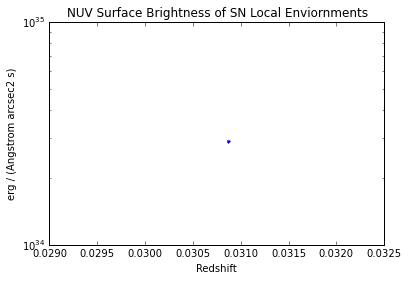

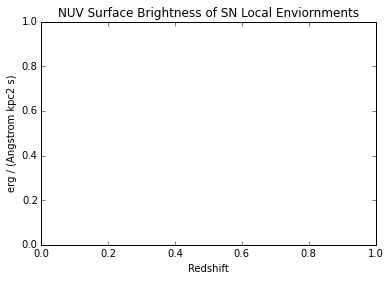

In [5]:
#Calculate values used in the ouptut tables. Individual tables are generated
#for nuv and fuv using both a 1kpc and 5kpc aperture
print('Calculating NUV values using a 1kpc radius aperture\n', flush=True)
nuv_1 = create_tables('NUV', fits_directory, 1)

print('Calculating FUV values using a 1kpc radius aperture\n', flush=True)
fuv_1 = create_tables('FUV', fits_directory, 1)

print('Calculating NUV values using a 5kpc radius aperture\n', flush=True)
nuv_5 = create_tables('NUV', fits_directory, 5)

print('Calculating FUV values using a 5kpc radius aperture\n', flush=True)
fuv_5 = create_tables('FUV', fits_directory, 5)


In [9]:
#Create plots and save them to file
print('Creating Plots\n', flush=True)
create_plots(nuv_1[0], 'NUV')
create_plots(fuv_1[0], 'FUV')


Creating Plots



/Users/Daniel/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:326: RuntimeWarning: invalid value encountered in double_scalars


In [10]:
#Create a table with the information desired to be in the .csv  
print('Joining Tables\n', flush=True)
nuv_1[0].keep_columns(['sn', 
                       'NUV 1kpc Luminosity',
                       'NUV 1kpc Luminosity Error',
                       'NUV 1kpc Surface Brightness',
                       'NUV 1kpc Surface Brightness Error'])

fuv_1[0].keep_columns(['sn', 
                        'FUV 1kpc Luminosity',
                        'FUV 1kpc Luminosity Error',
                        'FUV 1kpc Surface Brightness',
                        'FUV 1kpc Surface Brightness Error'])

nuv_5[0].remove_columns(['Flux', 
                         'Flux Error',
                         'NUV 5kpc Luminosity',
                         'NUV 5kpc Luminosity Error'])

fuv_5[0].remove_columns(['Flux', 
                         'Flux Error',
                         'FUV 5kpc Luminosity',
                         'FUV 5kpc Luminosity Error'])

merged_nuv_table = join(nuv_1[0], nuv_5[0], join_type='outer', keys='sn')
merged_fuv_table = join(fuv_1[0], fuv_5[0], join_type='outer', keys='sn')

merged_table = join(merged_nuv_table, merged_fuv_table, join_type='outer', keys=['sn'])
merged_table.rename_column('NUV 5kpc Exposure Time','NUV Exposure Time')
merged_table.rename_column('FUV 5kpc Exposure Time','FUV Exposure Time')
merged_table.rename_column('Redshift_1', 'Redshift')
merged_table.rename_column('Redshift Error_1', 'Redshift Error')

for row in merged_table:
    if str(row["Redshift"])=="--":
        row["Redshift"]=row["Redshift_2"]
        row["Redshift Error"]=row["Redshift Error_2"]
        
merged_table.remove_columns(["Redshift_2","Redshift Error_2"])

#rearrange the column order
final_table = merged_table['sn', 'Redshift', 'Redshift Error', 'NUV Exposure Time',
                          'NUV 1kpc Luminosity', 
                          'NUV 1kpc Luminosity Error',
                          'NUV 1kpc Surface Brightness', 
                          'NUV 1kpc Surface Brightness Error',
                          'NUV 5kpc Surface Brightness',
                          'NUV 5kpc Surface Brightness Error',
                          'FUV Exposure Time', 'FUV 1kpc Luminosity',
                          'FUV 1kpc Luminosity Error',
                          'FUV 1kpc Surface Brightness', 
                          'FUV 1kpc Surface Brightness Error',
                          'FUV 5kpc Surface Brightness',
                          'FUV 5kpc Surface Brightness Error',]

final_table.sort('sn')

merged_log = vstack([nuv_5[1],fuv_5[1]])
merged_log.sort('File Path')


#Write data to an output file
asc.write(final_table, output_file + '.csv', delimiter=",")
asc.write(merged_log, output_file + ' log.csv', delimiter=",")
print('Script finished')

Joining Tables

Script finished
